In [1]:
from IPython.display import HTML

In [2]:
import os
# Basic Imports
import sys
import time
import copy
import shutil
import zipfile
import numpy as np
import matplotlib.pyplot as plt
from matplotlib.patches import Rectangle, Circle

# Image Processing
from PIL import Image
import skimage.io as skio

# Deep Learning
from sklearn.metrics import (confusion_matrix, ConfusionMatrixDisplay,
                             accuracy_score, precision_score,
                             recall_score, f1_score)
import torch
from torch.utils.data import DataLoader
from torch import nn, optim
import torchvision
from torchvision import datasets, transforms
from torchsummary import summary
from mtcnn import MTCNN
from facenet_pytorch import InceptionResnetV1

In [3]:
device = (torch.device('cuda') if torch.cuda.is_available()
          else torch.device('cpu'))
print(f"Your Device is {device}.")

Your Device is cpu.


In [4]:
# Load the pre-trained model
detector = MTCNN()

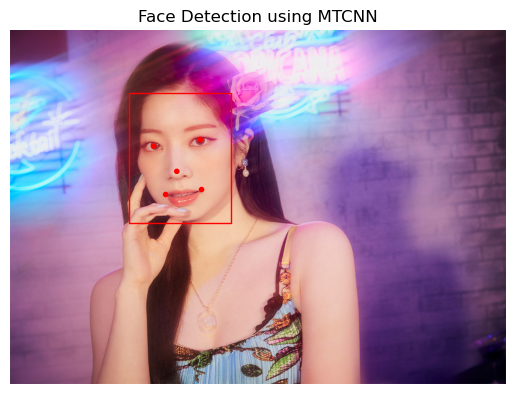


Output of MTCNN:
{'box': [288, 153, 245, 313], 'confidence': 0.9992341995239258, 'keypoints': {'left_eye': (347, 281), 'right_eye': (460, 265), 'nose': (403, 342), 'mouth_left': (376, 398), 'mouth_right': (463, 386)}}


In [5]:
# Load sample image
img = skio.imread(f'./data/raw_dataset/dahyun/dahyun (10).jpg')

# Surpress the loading printout by the mtcnn library
stdout = sys.stdout
sys.stdout = open(os.devnull, 'w')

# Run the Pre-trained Model on our image and save the output
faces = detector.detect_faces(img)

# Restore stdout
sys.stdout.close()
sys.stdout = stdout

# Plot the image
fig, ax = plt.subplots()
ax.imshow(img)

# Loop for all the faces detected by the model
for face in faces:
    # Add the bounding box
    x, y, w, h = face['box']
    rectangle = Rectangle((x, y), w, h, fill=False, color='red')
    ax.add_patch(rectangle)

    # Add left eye patch
    le_x, le_y = face['keypoints']['left_eye']
    le_circ = Circle((le_x, le_y), 5, fill=True, color='red')
    ax.add_patch(le_circ)

    # Add right eye patch
    re_x, re_y = face['keypoints']['right_eye']
    re_circ = Circle((re_x, re_y), 5, fill=True, color='red')
    ax.add_patch(re_circ)

    # Add nose patch
    n_x, n_y = face['keypoints']['nose']
    n_circ = Circle((n_x, n_y), 5, fill=True, color='red')
    ax.add_patch(n_circ)

    # Add left mouth patch
    lm_x, lm_y = face['keypoints']['mouth_left']
    lm_circ = Circle((lm_x, lm_y), 5, fill=True, color='red')
    ax.add_patch(lm_circ)

    # Add right mouth patch
    rm_x, rm_y = face['keypoints']['mouth_right']
    rm_circ = Circle((rm_x, rm_y), 5, fill=True, color='red')
    ax.add_patch(rm_circ)

# Adds context to the image
ax.set_title('Face Detection using MTCNN')
ax.set_axis_off()
plt.show()

# Save the figure as a PNG file
# plt.savefig("./images/Sample_FaceDetection.png")

# Create an HTML img tag to display the image
# img_tag = (f'<img src="./images/Sample_FaceDetection.png" alt="plots" style='
#            '"display:block;margin-left:auto;margin-right:auto;width:40%;">')

# Display the img tag in the Jupyter Notebook
# display(HTML(img_tag))
# plt.close()

# Display the output of the model . It contains a list of dictionaries
# Where each dictionary is a face the keys are:
# The bounding box, confidence, and keypoints (landmark positions)
print('\nOutput of MTCNN:')
print(faces[0])

In [6]:
# Surpress the loading printout by the mtcnn library
stdout = sys.stdout
sys.stdout = open(os.devnull, 'w')

# Create directory for the cropped images
crop_dir = './data/cropped_images'
if os.path.exists(crop_dir):
    shutil.rmtree(crop_dir)
os.makedirs(crop_dir)

# Loop for all members of twice
names = ['chaeyoung', 'dahyun', 'jeongyeon', 'jihyo',
         'mina', 'momo', 'nayeon', 'sana', 'tzuyu']
for name in names:
    # Create directory for individual members
    twice_dir = crop_dir+f'/{name}'
    if os.path.exists(twice_dir):
        shutil.rmtree(twice_dir)
    os.makedirs(twice_dir)

    # Loops thorugh all 20 raw images for each member
    for i in range(1, 21):
        # Load current image
        img = skio.imread(f'./data/raw_dataset/{name}/{name} ({i}).jpg')

        # Run the Pre-trained Model on our image and save the output
        faces = detector.detect_faces(img)

        # Loop for all the faces detected by the model
        for idx, face in enumerate(faces):
            # Save the cropped image as defined by the bounding box
            x, y, w, h = face['box']
            skio.imsave(f"{twice_dir}/{name}_{i}.jpg",
                        img[y:y+h, x:x+w])

# Restore stdout
sys.stdout.close()
sys.stdout = stdout


In [7]:
# Copy labeled images to train, validation, and test directories
def create_dataset(src, dst, range_, class_):
    """Copy images of class class_ within range_ from src to dst.

    Parameters
    ----------
    src : str
        source directory
    dst : str
        destination directory
    range_ : tuple
        tuple of min and max image index to copy
    class_ : str
        image class 
    """
    # If existing, delete dir to reset
    if os.path.exists(dst):
        shutil.rmtree(dst)

    # Create destination directory
    os.makedirs(dst)

    # Copies the image from source to destination directory
    fnames = [f'{class_}_{i}.jpg' for i in range(*range_)]
    for fname in fnames:
        src_file = os.path.join(src, fname)
        dst_file = os.path.join(dst, fname)
        shutil.copyfile(src_file, dst_file)

In [8]:
# looping through create_dataset for each class
classes = ['chaeyoung', 'dahyun', 'jeongyeon', 'jihyo',
           'mina', 'momo', 'nayeon', 'sana', 'tzuyu']
for class_ in classes:
    # Source directory
    src = 'data/cropped_images'

    # Train directory
    dst = f'data/train_val_test/train/{class_}'
    create_dataset(src+'/'+class_, dst, range_=(9, 21), class_=class_)

    # Validation directory
    dst = f'data/train_val_test/validation/{class_}'
    create_dataset(src+'/'+class_, dst, range_=(1, 5), class_=class_)

    # Test directory
    dst = f'data/train_val_test/test/{class_}'
    create_dataset(src+'/'+class_, dst, range_=(5, 9), class_=class_)

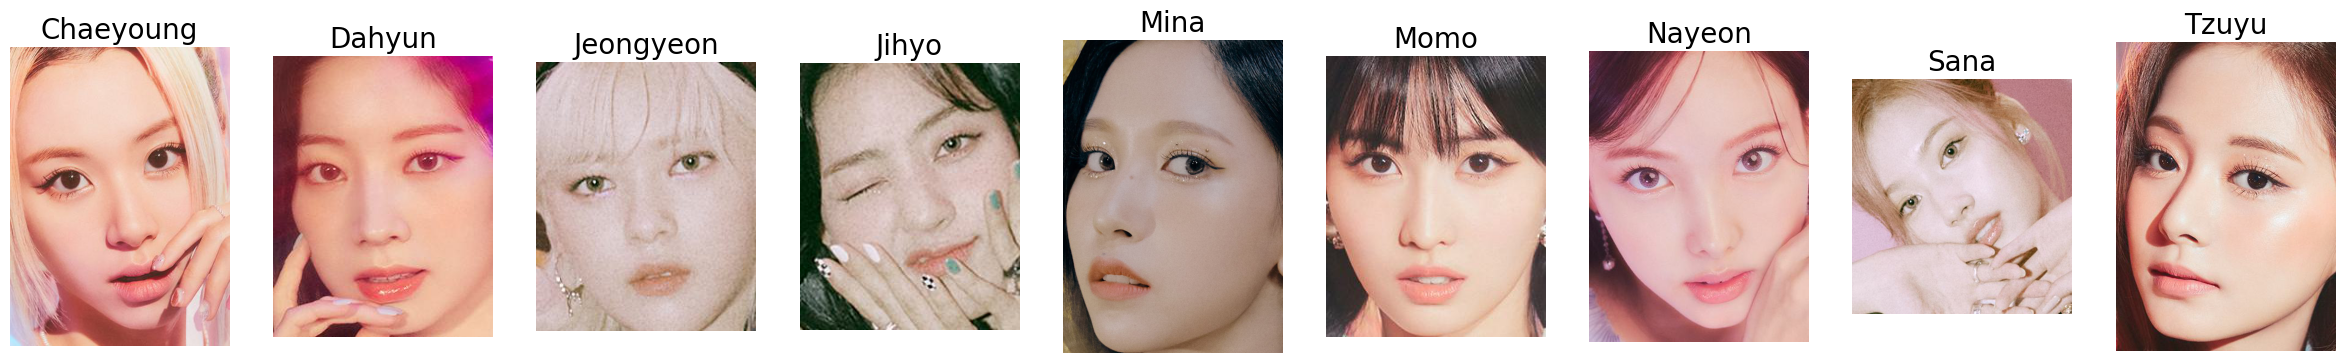

In [11]:
# Load sample images for each class in the train set
chaeyoung = Image.open('data/train_val_test/train/chaeyoung/chaeyoung_10.jpg')
dahyun = Image.open('data/train_val_test/train/dahyun/dahyun_10.jpg')
jeongyeon = Image.open('data/train_val_test/train/jeongyeon/jeongyeon_10.jpg')
jihyo = Image.open('data/train_val_test/train/jihyo/jihyo_10.jpg')
mina = Image.open('data/train_val_test/train/mina/mina_10.jpg')
momo = Image.open('data/train_val_test/train/momo/momo_10.jpg')
nayeon = Image.open('data/train_val_test/train/nayeon/nayeon_10.jpg')
sana = Image.open('data/train_val_test/train/sana/sana_10.jpg')
tzuyu = Image.open('data/train_val_test/train/tzuyu/tzuyu_10.jpg')

# Plot the images
fig, ax = plt.subplots(1, 9, figsize=(30, 10))
ax[0].imshow(chaeyoung)
ax[0].set_title('Chaeyoung', fontsize=20)
ax[0].set_axis_off()
ax[1].imshow(dahyun)
ax[1].set_title('Dahyun', fontsize=20)
ax[1].set_axis_off()
ax[2].imshow(jeongyeon)
ax[2].set_title('Jeongyeon', fontsize=20)
ax[2].set_axis_off()
ax[3].imshow(jihyo)
ax[3].set_title('Jihyo', fontsize=20)
ax[3].set_axis_off()
ax[4].imshow(mina)
ax[4].set_title('Mina', fontsize=20)
ax[4].set_axis_off()
ax[5].imshow(momo)
ax[5].set_title('Momo', fontsize=20)
ax[5].set_axis_off()
ax[6].imshow(nayeon)
ax[6].set_title('Nayeon', fontsize=20)
ax[6].set_axis_off()
ax[7].imshow(sana)
ax[7].set_title('Sana', fontsize=20)
ax[7].set_axis_off()
ax[8].imshow(tzuyu)
ax[8].set_title('Tzuyu', fontsize=20)
ax[8].set_axis_off()
# plt.show()

# Save the figure as a PNG file
# plt.savefig("./images/Sample_Faces.png")

# Create an HTML img tag to display the image
# img_tag = (f'<img src="./images/Sample_Faces.png" alt="plots" style='
#            '"display:block;margin-left:auto;margin-right:auto;width:100%;">')

# Display the img tag in the Jupyter Notebook
# display(HTML(img_tag))
# plt.close()

In [12]:
# Training set directory
train_dir = "data/train_val_test/train"

# Create data transformation to be use in calcultion of mean & std
data_transforms = transforms.Compose([
    transforms.Resize(size=(160, 160)),  # PTM are trained on 160 by 160 px
    transforms.ToTensor()
])
train_data = datasets.ImageFolder(root=train_dir, transform=data_transforms)

# Compute for the means and stds (for normalization)
imgs = torch.stack([img_t for img_t, _ in train_data], dim=3)
means = imgs.view(3, -1).mean(dim=1).numpy()
stds = imgs.view(3, -1).std(dim=1).numpy()

In [13]:
# Create data transformation for training, validation, and test sets
data_transforms = {
    'train': transforms.Compose([
        transforms.Resize(size=(160, 160)),  # PTM are trained on 160 by 160
        transforms.RandomHorizontalFlip(p=0.3),  # Data augmentation
        transforms.RandomPerspective(p=0.3),  # Data augmentation
        transforms.ColorJitter(brightness=0.3),  # Data augmentation
        transforms.ToTensor(),
        transforms.Normalize(means, stds)  # Normalize the image
    ]),
    'validation': transforms.Compose([
        transforms.Resize(size=(160, 160)),
        transforms.ToTensor(),
        transforms.Normalize(means, stds)
    ]),
    'test': transforms.Compose([
        transforms.Resize(size=(160, 160)),
        transforms.ToTensor(),
        transforms.Normalize(means, stds)
    ])
}

# Dataset directory
data_dir = 'data/train_val_test'

# loading image data using ImageFolder
image_datasets = {x: datasets.ImageFolder(os.path.join(data_dir, x),
                                          data_transforms[x])
                  for x in ['train', 'validation', 'test']}

# Dataloaders
dataloaders = {x: DataLoader(image_datasets[x], batch_size=36, shuffle=True)
               for x in ['train', 'validation', 'test']}

# Size of datasets
dataset_sizes = {x: len(image_datasets[x])
                 for x in ['train', 'validation', 'test']}

# Class names
class_names = image_datasets['train'].classes

In [14]:
# Load the PTM with its pre-trained weights base on facial recognition dataset
model = InceptionResnetV1(pretrained='vggface2')

# Must be set to True to be use in classification
model.classify = True

# Freeze the layers in our PTM
for param in model.parameters():
    param.requires_grad = False

In [15]:
# Change the last layer named logits to the ff layer with 4 output channels
model.logits = nn.Sequential(nn.Linear(512*1*1, 512),
                             nn.ReLU(),
                             nn.Dropout(0.4),
                             nn.Linear(512, 9),
                             )

# Transfer the model to device (GPU) for faster training
model = model.to(device)

# set the loss function
criterion = nn.CrossEntropyLoss()

# only the parameters of the classifier are being optimized
optimizer = optim.Adam(model.logits.parameters(), lr=0.001)

In [16]:
def train_model(model, criterion, optimizer, num_epochs=25):
    """Function that trains the model using the given loss function,
    optimizer and number of epochs."""
    # Tracks training time
    since = time.time()

    # Saves the best model here later
    best_model_wts = copy.deepcopy(model.state_dict())
    best_acc = 0.0

    # Loop for all epoch
    for epoch in range(num_epochs):
        # Prints only every 5 epoch
        if epoch == 0 or epoch % 5 == 4:
            print(f'\nEpoch {epoch + 1}/{num_epochs}')
            print('-' * 10)

        # Each epoch has a training and validation phase
        for phase in ['train', 'validation']:
            if phase == 'train':
                model.train()  # Set model to training mode
            else:
                model.eval()   # Set model to evaluate mode

            # Tracker for loss
            running_loss = 0.0
            running_corrects = 0

            # Iterate over data.
            for inputs, labels in dataloaders[phase]:
                inputs = inputs.to(device)
                labels = labels.to(device)

                # Zero the parameter gradients
                optimizer.zero_grad()

                # Forward
                # Track history if only in train
                with torch.set_grad_enabled(phase == 'train'):
                    outputs = model(inputs)
                    _, preds = torch.max(outputs, 1)
                    loss = criterion(outputs, labels)

                    # Backward + optimize only if in training phase
                    if phase == 'train':
                        loss.backward()
                        optimizer.step()

                # Statistics
                running_loss += loss.item() * inputs.size(0)
                running_corrects += torch.sum(preds == labels.data)

            # Calculate loss and accuracy of current epoch
            epoch_loss = running_loss / dataset_sizes[phase]
            epoch_acc = running_corrects.double() / dataset_sizes[phase]

            # Prints only every 4 epoch
            if epoch == 0 or epoch % 5 == 4:
                print(f'{phase} Loss: {epoch_loss:.4f} Acc: {epoch_acc:.4f}')

            # Deep copy the model if it beats the current best model
            if phase == 'validation' and epoch_acc > best_acc:
                best_acc = epoch_acc
                best_model_wts = copy.deepcopy(model.state_dict())

    # Print out model summary
    time_elapsed = time.time() - since
    print(f'\nTraining complete in '
          f'{time_elapsed // 60:.0f}m {time_elapsed % 60:.0f}s')
    print(f'Best val Acc: {best_acc:4f}')

    # load best model weights
    model.load_state_dict(best_model_wts)

    return model

In [17]:
# Train the model by calling the train_model function
model = train_model(model.cuda(),
                    criterion,
                    optimizer,
                    num_epochs=30)

AssertionError: Torch not compiled with CUDA enabled

In [ ]:
# Calculate the image count per class and the total image count
chaeyoung_cnt = len(os.listdir('./data/cropped_images/chaeyoung'))
dahyun_cnt = len(os.listdir('./data/cropped_images/dahyun'))
jeongyeon_cnt = len(os.listdir('./data/cropped_images/jeongyeon'))
jihyo_cnt = len(os.listdir('./data/cropped_images/jihyo'))
mina_cnt = len(os.listdir('./data/cropped_images/mina'))
momo_cnt = len(os.listdir('./data/cropped_images/momo'))
nayeon_cnt = len(os.listdir('./data/cropped_images/nayeon'))
sana_cnt = len(os.listdir('./data/cropped_images/sana'))
tzuyu_cnt = len(os.listdir('./data/cropped_images/tzuyu'))
total_cnt = (chaeyoung_cnt + dahyun_cnt + jeongyeon_cnt +
             jihyo_cnt + mina_cnt + momo_cnt +
             nayeon_cnt + sana_cnt + tzuyu_cnt)

# Calculate the PCC
pcc = ((chaeyoung_cnt/total_cnt)**2 +
       (dahyun_cnt/total_cnt)**2 +
       (jeongyeon_cnt/total_cnt)**2 +
       (jihyo_cnt/total_cnt)**2 +
       (mina_cnt/total_cnt)**2 +
       (momo_cnt/total_cnt)**2 +
       (nayeon_cnt/total_cnt)**2 +
       (sana_cnt/total_cnt)**2 +
       (tzuyu_cnt/total_cnt)**2
       )
print(f"     PCC = {pcc*100:.2f}%")
print(f"1.25*PCC = {1.25*pcc*100:.2f}%")

In [ ]:
def evaluate(model, test_loader):
    """Function that test the model using the prepared test loader."""
    # Initialize counting of correct and total images
    correct = 0
    total = 0

    # Set no grad since this is evaluation mode
    with torch.no_grad():
        # Load the image and use the model to predict its label
        for imgs, labels in test_loader:
            imgs = imgs.to(device)
            labels = labels.to(device)
            outputs = model(imgs)
            _, predicted = torch.max(outputs, dim=1)
            total += labels.shape[0]
            correct += int((predicted == labels).sum())

    return predicted, labels

In [ ]:
# Evaluate the model by calling the evaluate function
y_pred_tensor, y_true_tensor = evaluate(model, dataloaders['test'])
y_pred = y_pred_tensor.cpu().numpy()
y_true = y_true_tensor.cpu().numpy()

# Display Confusion Matrix
fig, ax = plt.subplots(1, 1, figsize=(5, 5))
cm = confusion_matrix(y_true, y_pred)
disp = ConfusionMatrixDisplay(cm)
disp.plot(ax=ax, cmap='RdPu')
disp.ax_.set_xticklabels(classes, fontsize=8)
disp.ax_.set_yticklabels(classes, fontsize=8)
disp.im_.colorbar.remove()
ax.tick_params(axis='x', rotation=45)
ax.set_title('Model Confusion Matrix')
# plt.show()

# Save the figure as a PNG file
plt.tight_layout()
plt.savefig("./images/Confusion_Matrix.png")

# Create an HTML img tag to display the image
img_tag = (f'<img src="./images/Confusion_Matrix.png" alt="plots" style='
           '"display:block;margin-left:auto;margin-right:auto;width:30%;">')

# Display the img tag in the Jupyter Notebook
display(HTML(img_tag))
plt.close()

# Print Evaluation scores
print('Model Evaluation:')
print(f'Accuracy Score: {accuracy_score(y_true, y_pred)*100:.2f}')
print(f'Precision Score: '
      f'{precision_score(y_true, y_pred, average="macro")*100:.2f}')
print(f'Recall Score: '
      f'{recall_score(y_true, y_pred, average="macro")*100:.2f}')
print(f'F1 Score: {f1_score(y_true, y_pred,  average="macro")*100:.2f}')

In [ ]:
# Load the pre-trained model
detector = MTCNN()

# Load sample image
img = skio.imread(f"./data/group_image/twice_0.jpg")

# Surpress the loading printout by the mtcnn library
stdout = sys.stdout
sys.stdout = open(os.devnull, 'w')

# Saves the output of the model (including bounding box)
faces = detector.detect_faces(img)

# Restore stdout
sys.stdout.close()
sys.stdout = stdout

# If existing, delete dir to reset
face_recog_dir = 'data/face_recog'
if os.path.exists(face_recog_dir):
    shutil.rmtree(face_recog_dir)

# Create destination directory
os.makedirs(f"{face_recog_dir}/test/dahyun")

# Loop for all the faces detected by the model
for idx, face in enumerate(faces):
    # Save the cropped image as defined by the bounding box
    x, y, w, h = face['box']
    skio.imsave(f"./{face_recog_dir}/test/dahyun/sample_{idx}.jpg",
                img[y:y+h, x:x+w])

# loading cropped image data using ImageFolder
face_datasets = datasets.ImageFolder(os.path.join(face_recog_dir, 'test'),
                                     data_transforms['test'])

# Cropped Image Dataloaders
face_dataloaders = DataLoader(face_datasets, batch_size=9, shuffle=False)

# Get batch of images from the test DataLoader
images, _ = next(iter(face_dataloaders))
images = images.to(device)

# Predicts the images using the trained model
outputs = model(images)
_, predicted = torch.max(outputs, 1)

# Gets the class labels from the predictions
names = [classes[i] for i in predicted]

# Plot the image
fig, ax = plt.subplots(figsize=(10, 10))
ax.imshow(img)

# Loop for all the faces detected by the model
for idx, face in enumerate(faces):
    # Add the bounding box
    x, y, w, h = face['box']
    rectangle = Rectangle((x, y), w, h, fill=False, color='#FE7BA3')
    ax.add_patch(rectangle)

    # Add the face labels
    bbox_props = dict(boxstyle="round,pad=0.2", fc="#FE7BA3", ec="#FE7BA3")
    ax.text(x+3, y-5, names[idx], fontsize=7, color='white', bbox=bbox_props)

# Adds context to the image
ax.set_title(f'\nFace Recognition of Twice')
ax.set_axis_off()
# plt.show()

# Save the figure as a PNG file
plt.savefig("./images/Twice_Recognition.png")

# Create an HTML img tag to display the image
img_tag = (f'<img src="./images/Twice_Recognition.png" alt="plots" style='
           '"display:block;margin-left:auto;margin-right:auto;width:70%;">')

# Display the img tag in the Jupyter Notebook
display(HTML(img_tag))
plt.close()